In [1]:
!pip install signatory

    100% |████████████████████████████████| 40kB 5.1MB/s ta 0:00:011
  Complete output from command /anaconda3/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/c1/xvfpy4j10qsg8pm4pwqrbrpr0000gn/T/pip-install-iobvewal/signatory/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /private/var/folders/c1/xvfpy4j10qsg8pm4pwqrbrpr0000gn/T/pip-wheel-wf669014 --python-tag cp37:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.7-x86_64-3.7
  creating build/lib.macosx-10.7-x86_64-3.7/signatory
  copying src/signatory/compatibility.py -> build/lib.macosx-10.7-x86_64-3.7/signatory
  copying src/signatory/backend.py -> build/lib.macosx-10.7-x86_64-3.7/signatory
  copying src/signatory/logsignature_module.py -> build/lib.macosx-10.7-x86_64-3.7/signatory
  copying src/signatory/signature_module.py -> build/lib.macosx

In [0]:
import logging

import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm, trange

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import optim
import torchtext

import signatory


In [3]:
import os
os.environ['CUDA_VISBLE_DEVICES'] = '0'
use_cude = True

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Found GPU at: /device:GPU:0


'Tesla K80'

# prepare data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv(r"/content/drive/My Drive/berkeley/major-3.txt", header = None) #major-3, no-complex-oversample

data_train, data_val = train_test_split(data[1:], test_size=0.20, random_state=2018, stratify=data[2][1:])
train_tag = data_train[2].values.tolist()
val_tag = data_val[2].values.tolist()

tags2vals = list(set(train_tag))
tag2idx = {t: i for i, t in enumerate(tags2vals)}
print(tag2idx)

train_label = [tag2idx.get(l) for l in train_tag]
val_label = [tag2idx.get(l) for l in val_tag]

df1 = pd.DataFrame({'sentence':data_train[0], 'label': train_label})
headers = ['sentence', 'label']
df1.columns = headers
df1.to_csv("/content/drive/My Drive/berkeley/data_train(ov).csv")

df2 = pd.DataFrame({'sentence':data_val[0], 'label': val_label})
headers = ['sentence', 'label']
df2.columns = headers
df2.to_csv("/content/drive/My Drive/berkeley/data_val(ov).csv")

#weight on the optimiser
weight_dic={'NONE':1818, 'TREAT_FOR_DIS':830, 'DISONLY':629, 'TREATONLY':169, 'PREVENT':63, 'SIDE_EFF':30, 'VAGUE':37, 'TREAT_NO_FOR_DIS':4 }
weight_list=[]
for i, t in enumerate(tags2vals):
  weight_list.append(1/float(weight_dic.get(t)))
print(weight_list)

{'DISONLY': 0, 'TREAT_FOR_DIS': 1, 'NONE': 2}
[629.0, 830.0, 1818.0]


# load data

In [7]:
text = torchtext.data.Field(lower=True, batch_first=True)
target = torchtext.data.Field(sequential=False, use_vocab=False, is_target=True)

train = torchtext.data.TabularDataset(path='/content/drive/My Drive/berkeley/data_train(ov).csv', format='csv',
                                      fields={'sentence': ('text',text),
                                              'label': ('target',target)})

val = torchtext.data.TabularDataset(path='/content/drive/My Drive/berkeley/data_val(ov).csv', format='csv',
                                      fields={'sentence': ('text',text),
                                              'label': ('target',target)})
print(len(train))
print(len(val))

2621
656


In [8]:
#load pre-trained embedding
text.build_vocab(train)

text.vocab.load_vectors(torchtext.vocab.Vectors('/content/drive/My Drive/berkeley/dic_vec.txt')) # bert.vec.text, dic_vec.txt, mymodel2_vec.txt

print(text.vocab.vectors.shape)

torch.Size([8285, 768])


In [0]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE('not majority', random_state=2018)
# train= smote.fit(train)


# from collections import Counter
# tr_tags = [tags2vals[p] for p in train]
# Counter(tr_tags)

# Model

In [0]:
class BiLSTM(nn.Module):
    def __init__(self, pretrained_lm, padding_idx, num_labels=8, static=False, hidden_dim=768, lstm_layer=2, dropout=0.2, truncate_order=2):
        super(BiLSTM, self).__init__()

        self.num_labels = num_labels
        self.hidden_dim = hidden_dim
        self.truncate_order = truncate_order
        self.dropout = nn.Dropout(p=dropout)
        self.embedding = nn.Embedding.from_pretrained(pretrained_lm)
        self.embedding.padding_idx = padding_idx
        if static:
            self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(input_size=self.embedding.embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=lstm_layer, 
                            dropout = dropout,
                            bidirectional=True)
        self.linear1 = nn.Linear(self.hidden_dim, 4)
        self.linear2 = nn.Linear( 20, self.hidden_dim )
        
        self.classifier = nn.Linear(hidden_dim, self.num_labels)

    
    def forward(self, sents, labels):
        x = self.embedding(sents)
        x = torch.transpose(x, dim0=1, dim1=0).to(dtype=torch.float32) #(seq_len, batch, input_size)
        
        lstm_out, (h_n, c_n) = self.lstm(x) # h=(num_layers * num_directions, batch, hidden_size)

        bi = lstm_out.view(x.size()[0], x.size()[1], 2, 768) #, self.hidden_dim), output.view(seq_len, batch, num_directions, hidden_size)

        avg_lstm = (bi[:, :, 0, :] + bi[:, :, 1, :])/2 #(seq_len, batch, hidden_size),

        reduced_lstm = self.linear1(self.dropout(avg_lstm)) #(seq_len, batch, 4)

        reduced_lstm = torch.transpose(reduced_lstm, dim0=1, dim1=0)

        sig_lstm = signatory.signature(reduced_lstm, self.truncate_order)

        out_lstm = self.linear2(self.dropout(sig_lstm))

        logits = self.classifier(self.dropout(out_lstm))

        # logits = self.classifier(self.dropout(avg_lstm))
        
        # outputs = (logits,) + (lstm_out, h_n)  
        outputs = (logits,) + (lstm_out, h_n) 
        
        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = nn.MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weight_list).cuda())
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs
        return outputs #loss, logits, lstm_out, h_n-lstm

In [0]:
batch_size = 128
train_iter = torchtext.data.BucketIterator(dataset=train,
                                               batch_size=batch_size,
                                               sort_key=lambda x: x.text.__len__(),
                                               shuffle=True,
                                               sort=False)
val_iter = torchtext.data.BucketIterator(dataset=val,
                                             batch_size=batch_size,
                                             sort_key=lambda x: x.text.__len__(),
                                             train=False,
                                             sort=False)
model = BiLSTM(text.vocab.vectors, num_labels=3, lstm_layer=2, padding_idx=text.vocab.stoi[text.pad_token], 
               hidden_dim=768, static = False, truncate_order=2).cuda()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-3)

In [12]:
import time
start = time.time()

val_loss_tt = []
val_acc_tt = []
train_loss_tt = []
f1_score_tt=[]
precision_score_tt=[]
recall_score_tt=[]
auc_score_rr=[]

none = []
disonly = []
PREVENT = []
TREAT_FOR_DIS = []
TREAT_NO_FOR_DIS= []
VAGUE = []
SIDE_EFF = []
TREATONLY = []

CUDA_LAUNCH_BLOCKING=1 
train_loss_set = []

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)



# Number of training epochs (authors recommend between 2 and 4)
epochs = 25

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for train_batch in iter(train_iter):
    step =0
    
    # Add batch to GPU
    # Unpack the inputs from our dataloader
    x = train_batch.text.cuda()
    y = train_batch.target.type(torch.long).cuda()
    
    
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    
    # Forward pass

    outputs = model.forward(x, y)
  
    #print(outputs)
    loss, logits = outputs[:2]
    train_loss_set.append(loss)  

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient

    optimizer.step()
    optimizer.zero_grad()
    
    step += 1
    
    
    # Update tracking variables
    tr_loss += loss
    nb_tr_examples += x.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
  train_loss_tt.append(tr_loss/nb_tr_steps)
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss2, eval_accuracy2 = 0, 0
  nb_eval_steps2, nb_eval_examples2 = 0, 0
  predictions , true_labels = [], []

  # Evaluate data for one epoch
  for val_batch in iter(val_iter):
    
    
    
    # Add batch to GPU
    
    # Unpack the inputs from our dataloader
    val_x = val_batch.text.cuda()
    val_y = val_batch.target.type(torch.long).cuda()
    
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      ot = model.forward(val_x, None)
      logits = ot[0]
      outputs = model.forward(val_x, val_y)
      loss = outputs[0]
    
    # Move logits and labels to CPu
    
    m = nn.Softmax()
    pred = m(logits).to('cpu').detach().numpy()
    label_ids = val_y.to('cpu').numpy()
    
    predictions.extend([p for p in np.argmax(pred, axis=1)])
    true_labels.append(label_ids)
    
    
    tmp_eval_accuracy = flat_accuracy(pred, label_ids)
    #print(tmp_eval_accuracy)
    
    eval_accuracy2 += tmp_eval_accuracy
    nb_eval_steps2 += 1
    eval_loss2 += loss
    

  print("Validation loss: {}".format(eval_loss2/nb_eval_steps2))
  print("Validation Accuracy: {}".format(eval_accuracy2/nb_eval_steps2))
  pred_tags = [tags2vals[p] for p in predictions]
  valid_tags = [tags2vals[l_i] for l in true_labels for l_i in l]
  

  print('pred:', pred_tags)
  print('val:', valid_tags)
  print("F1-Score: {}".format(f1_score(valid_tags, pred_tags, average=None, labels=tags2vals)))
  print("Precision-Score: {}".format(precision_score( valid_tags, pred_tags, average=None, labels=tags2vals)))
  print("Recall-Score: {}".format(recall_score( valid_tags, pred_tags, average=None, labels=tags2vals)))
  #print("AUC-Score: {}".format(roc_auc_score( valid_tags, pred_tags, average=None)))#, labels=tags2vals)))

  f1 = f1_score(valid_tags, pred_tags, average=None, labels=tags2vals)
  precision = precision_score(valid_tags, pred_tags, average='macro', labels=tags2vals)
  recall = recall_score(valid_tags, pred_tags, average='macro', labels=tags2vals)
  #acu = roc_auc_score(valid_tags, pred_tags, average='macro')#, labels=tags2vals)


  val_loss_tt.append(eval_loss2/nb_eval_steps2)
  val_acc_tt.append(eval_accuracy2/nb_eval_steps2)
  f1_score_tt.append(sum(f1)/len(f1))
  precision_score_tt.append(precision)
  recall_score_tt.append(recall)
  #auc_score_tt.append(auc)

  none.append(f1[0])
  disonly.append(f1[1])
  PREVENT.append(f1[2])
  # TREAT_FOR_DIS.append(f1[3])
  # TREAT_NO_FOR_DIS.append(f1[4])
  # VAGUE.append(f1[5])
  # SIDE_EFF.append(f1[6])
  # TREATONLY.append(f1[7])

end = time.time()
print('train time:', end - start)

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss: 0.7670528888702393


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
Epoch:   4%|▍         | 1/25 [00:16<06:39, 16.64s/it]

Validation loss: 0.6943528056144714
Validation Accuracy: 0.5651041666666666
pred: ['NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE

Epoch:   8%|▊         | 2/25 [00:32<06:19, 16.52s/it]

Validation loss: 0.6145201921463013
Validation Accuracy: 0.6041666666666666
pred: ['NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 

Epoch:  12%|█▏        | 3/25 [00:49<06:05, 16.60s/it]

Validation loss: 0.4360544681549072
Validation Accuracy: 0.734375
pred: ['TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_

Epoch:  16%|█▌        | 4/25 [01:06<05:52, 16.80s/it]

Validation loss: 0.4569408893585205
Validation Accuracy: 0.7174479166666666
pred: ['TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', '

Epoch:  20%|██        | 5/25 [01:23<05:32, 16.63s/it]

Validation loss: 0.48629504442214966
Validation Accuracy: 0.671875
pred: ['NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 

Epoch:  24%|██▍       | 6/25 [01:39<05:14, 16.56s/it]

Validation loss: 0.43904948234558105
Validation Accuracy: 0.6953125
pred: ['NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE

Epoch:  28%|██▊       | 7/25 [01:56<04:58, 16.57s/it]

Validation loss: 0.4157620370388031
Validation Accuracy: 0.7018229166666666
pred: ['NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NON

Epoch:  32%|███▏      | 8/25 [02:13<04:43, 16.67s/it]

Validation loss: 0.3920263648033142
Validation Accuracy: 0.7473958333333334
pred: ['TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'T

Epoch:  36%|███▌      | 9/25 [02:30<04:29, 16.81s/it]

Validation loss: 0.369488924741745
Validation Accuracy: 0.7877604166666666
pred: ['TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NON

Epoch:  40%|████      | 10/25 [02:46<04:10, 16.68s/it]

Validation loss: 0.3765307366847992
Validation Accuracy: 0.7591145833333334
pred: ['TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE',

Epoch:  44%|████▍     | 11/25 [03:03<03:54, 16.74s/it]

Validation loss: 0.3943856656551361
Validation Accuracy: 0.7408854166666666
pred: ['NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FO

Epoch:  48%|████▊     | 12/25 [03:20<03:38, 16.79s/it]

Validation loss: 0.34746044874191284
Validation Accuracy: 0.8177083333333334
pred: ['TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'N

Epoch:  52%|█████▏    | 13/25 [03:37<03:21, 16.77s/it]

Validation loss: 0.3771435618400574
Validation Accuracy: 0.8203125
pred: ['TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'DISONLY', 'NONE', 'TREAT_FOR

Epoch:  56%|█████▌    | 14/25 [03:53<03:03, 16.71s/it]

Validation loss: 0.35926708579063416
Validation Accuracy: 0.8307291666666666
pred: ['TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE',

Epoch:  60%|██████    | 15/25 [04:10<02:47, 16.70s/it]

Validation loss: 0.3485141694545746
Validation Accuracy: 0.7890625
pred: ['TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'DISONLY', 'NONE', 'TREAT_FOR

Epoch:  64%|██████▍   | 16/25 [04:27<02:31, 16.78s/it]

Validation loss: 0.3484586179256439
Validation Accuracy: 0.8229166666666666
pred: ['TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS',

Epoch:  68%|██████▊   | 17/25 [04:43<02:13, 16.64s/it]

Validation loss: 0.4046812057495117
Validation Accuracy: 0.7877604166666666
pred: ['TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'DISONLY', 'NONE', 'TREAT_FOR_DIS',

Epoch:  72%|███████▏  | 18/25 [05:00<01:56, 16.57s/it]

Validation loss: 0.37445804476737976
Validation Accuracy: 0.8229166666666666
pred: ['TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', '

Epoch:  76%|███████▌  | 19/25 [05:16<01:38, 16.49s/it]

Validation loss: 0.32834959030151367
Validation Accuracy: 0.8125
pred: ['TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'DISONLY', 'NONE', 'TREAT_FO

Epoch:  80%|████████  | 20/25 [05:33<01:22, 16.57s/it]

Validation loss: 0.3991856276988983
Validation Accuracy: 0.8515625
pred: ['TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TRE

Epoch:  84%|████████▍ | 21/25 [05:49<01:06, 16.65s/it]

Validation loss: 0.3560353219509125
Validation Accuracy: 0.8502604166666666
pred: ['TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE

Epoch:  88%|████████▊ | 22/25 [06:06<00:50, 16.67s/it]

Validation loss: 0.38359975814819336
Validation Accuracy: 0.8125
pred: ['TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'DISONLY', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_F

Epoch:  92%|█████████▏| 23/25 [06:23<00:33, 16.72s/it]

Validation loss: 0.4361208379268646
Validation Accuracy: 0.8606770833333334
pred: ['TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE'

Epoch:  96%|█████████▌| 24/25 [06:40<00:16, 16.78s/it]

Validation loss: 0.4010099172592163
Validation Accuracy: 0.83984375
pred: ['TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NON

Epoch: 100%|██████████| 25/25 [06:56<00:00, 16.69s/it]

Validation loss: 0.48211121559143066
Validation Accuracy: 0.8411458333333334
pred: ['TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'DISONLY'

Text(0.5, 0, 'epochs')

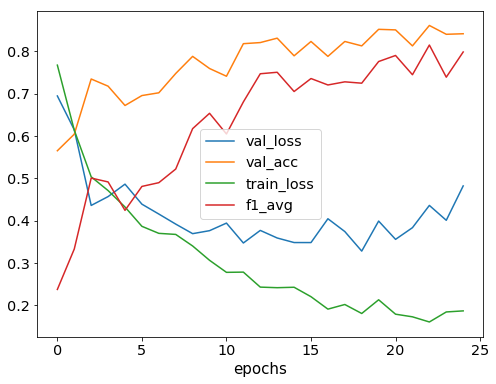

In [13]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.plot(range(epochs), val_loss_tt, label='val_loss')
plt.plot(range(epochs), val_acc_tt, label='val_acc')
plt.plot(range(epochs), train_loss_tt, label='train_loss')
plt.plot(range(epochs), f1_score_tt, label='f1_avg')
plt.legend()
plt.xlabel('epochs', fontsize=15)
# plt.savefig('/content/drive/My Drive/berkeley/sig+bilstm.png', dpi=500)


In [14]:
tags2vals

['DISONLY', 'TREAT_FOR_DIS', 'NONE']

Text(0, 0.5, 'avg f1 score ')

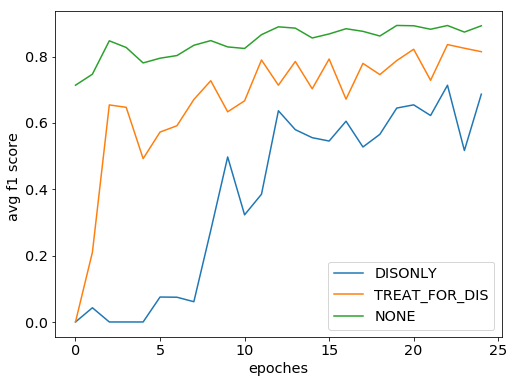

In [15]:

plt.plot(range(epochs), none, label='%s'%tags2vals[0])
plt.plot(range(epochs), disonly, label='%s'%tags2vals[1])
plt.plot(range(epochs), PREVENT, label='%s'%tags2vals[2])
# plt.plot(range(epochs), TREAT_FOR_DIS, label='%s'%tags2vals[3])
# plt.plot(range(epochs), TREAT_NO_FOR_DIS, label='%s'%tags2vals[4])
# plt.plot(range(epochs), VAGUE, label='%s'%tags2vals[5])
# plt.plot(range(epochs), SIDE_EFF, label='%s'%tags2vals[6])
# plt.plot(range(epochs), TREATONLY, label='%s'%tags2vals[7])
plt.legend()
plt.xlabel('epoches')
plt.ylabel('avg f1 score ')

# plt.savefig('/content/drive/My Drive/berkeley/sig+bilstm2.png', dpi=500)

In [21]:
n=-5
print('accuracy', val_acc_tt[n])
print('f1', f1_score_tt[n])
print('recall', recall_score_tt[n])
print('precision', precision_score_tt[n])

accuracy 0.8502604166666666
f1 0.7898605785869718
recall 0.7727393088838873
precision 0.8180679051550758
